# Loading the unprocessed dataset into Pandas dataframes.

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-poster')

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

In [2]:
datasetsFolder = {}

for dirname, _, filenames in os.walk(r'R:\Ryerson\Misc\Datasets\Predict Droughts using Weather & Soil Data\\'):
    for filename in filenames:
        if 'train' in filename:
            datasetsFolder['train'] = os.path.join(dirname, filename)
        if 'valid' in filename:
            datasetsFolder['valid'] = os.path.join(dirname, filename)
        if 'test' in filename:
            datasetsFolder['test'] = os.path.join(dirname, filename)

In [3]:
allDatasets = { k: pd.read_csv(datasetsFolder[k]).set_index(['fips', 'date'])
    for k in datasetsFolder.keys()}

# Pre-processing data to create feature and response matrices.

In [4]:
def interpolate_NaN_values(sourceArray, interpolationKind='linear'):
    allIndexes = np.arange(sourceArray.shape[0])
    allGoodIndexes, = np.where(np.isfinite(sourceArray))
    f = interp1d(allGoodIndexes,
                 sourceArray[allGoodIndexes],
                 bounds_error=False,
                 copy=False,
                 fill_value='extrapolate',
                 kind=interpolationKind)
    return f(allIndexes)

In [5]:
def loadXYMatrices(
    df,
    randomState = 42, # random state is kept at 42 as per convention
    windowSize = 30, # decides number of days per each output sample for which the corresponding drought score is returned
    targetSize = 1, # decides how many weeks' worth of drought scores are returned starting the first day of the week following windowSize 
    ):
        rawDF = allDatasets[df]

        soilDF = pd.read_csv(r'R:\Ryerson\Misc\Datasets\Predict Droughts using Weather & Soil Data\soil_data.csv')

        timeSeriesDataColumns = sorted([c for c in rawDF.columns if c not in ["fips", "date", "score"]])
        #timeSeriesDataColumns are the 18 meteorological indicators
        print('\ntimeSeriesDataColumns: \n')
        for i_1 in timeSeriesDataColumns:
            print(i_1, '\n')

        #staticDataColumns are the 29 soil data indicators
        staticDataColumns = sorted([c for c in soilDF.columns if c not in ["fips", "lat", "lon"]])
        '''print('\nstaticDataColumns: ')
        for i_2 in staticDataColumns:
            print(i_2, '\n')'''

        count = 0
        scoreDF = rawDF.dropna(subset=["score"])

        X_static = np.empty((len(rawDF) // windowSize, len(staticDataColumns)))
        # the shape of this uninitialized array will be (19300680/windowSize, 28)
        '''print('X_static Shape: ', X_static.shape)'''

        X_time = np.empty((len(rawDF) // windowSize, windowSize, len(timeSeriesDataColumns))) 
        # the shape of this uninitialized array will be (19300680/windowSize, windowSize, 18)
        print('X_time Shape: ', X_time.shape)

        y_past = np.empty((len(rawDF) // windowSize, windowSize))
        # the shape of this uninitialized array will be (19300680/windowSize, windowSize)
        '''print('y_past Shape: ', y_past.shape)'''

        y_target = np.empty((len(rawDF) // windowSize, targetSize))
        # the shape of this uninitialized array will be (19300680/windowSize, targetSize)
        print('y_target Shape: ', y_target.shape)

        if randomState is not None:
            np.random.seed(randomState)
            
        for uniqueFIPScode in tqdm(scoreDF.index.get_level_values(0).unique()): #for every unique FIPS county code
            
            if randomState is not None:
                startingPoint = np.random.randint(1, windowSize) #return random integers from 1 to 30 (30 not included)
            else:
                startingPoint = 1
            
            fipsDF = rawDF[(rawDF.index.get_level_values(0) == uniqueFIPScode)] #store the df sample at [index = current unique value of fips] 
            X = fipsDF[timeSeriesDataColumns].values #individual X = current sample values of the 18 meteorological columns 
            y = fipsDF["score"].values #individual y = current samples' values of the column 'score' as ndarray
            XStat = soilDF[soilDF["fips"] == uniqueFIPScode][staticDataColumns].values[0] #individual soil data sample = return as ndarray all the 29 column values minus the axis labels
            
            for i in range(startingPoint, len(y) - (windowSize + targetSize * 7), windowSize):
                X_time[count, :, : len(timeSeriesDataColumns)] = X[i : i + windowSize]
                y_past[count] = interpolate_NaN_values(y[i : i + windowSize])
                tempY = y[i + windowSize : i + windowSize + targetSize * 7]
                y_target[count] = np.array(tempY[~np.isnan(tempY)][:targetSize])
                X_static[count] = XStat
                count += 1
        
        print(f"\n\n-----------------------------------\nLoaded {count} samples successfully.\n-----------------------------------\n\n")
        matrices = [X_time[:count], y_target[:count]]
        #If you wish to inculcate Soil data in the training of your model and require the Soil data array for the same then uncomment the following line of code: 
        #matrices.append(X_static[:count])
        #If you require the interpolated past drought values for every day in the dataset then uncomment the following line of code: 
        #matrices.append(y_past[:count])
        return matrices

# Defining function to scale features using RobustScaler.

In [6]:
scalerDict = {}

def scaleFeatures(sourceArray, fit=False):
    for feature in tqdm(range(sourceArray.shape[-1])): #printing a progress bar for each of the 18 meteorological indicators
        if fit:
            scalerDict[feature] = RobustScaler().fit(sourceArray[:, feature].reshape(-1, 1))
        sourceArray[:, feature] = scalerDict[feature].transform(sourceArray[:, feature].reshape(-1, 1)).reshape(1, -1)
    return sourceArray

# Creating the Feature and Response matrices.

In [7]:
# There are 3108 counties in the training dataset.

# For each county, there are 6210 observations i.e. there is one observation for every day of 2001-2017. 

# Meaning there are a total of 3108 x 6210 = 19,300,680 observations in the training dataset.

In [8]:
X_train_unscaled, y_target_train = loadXYMatrices("train")
X_valid_unscaled, y_target_valid = loadXYMatrices("valid")
X_test_unscaled, y_target_test = loadXYMatrices("test")


timeSeriesDataColumns: 

PRECTOT 

PS 

QV2M 

T2M 

T2MDEW 

T2MWET 

T2M_MAX 

T2M_MIN 

T2M_RANGE 

TS 

WS10M 

WS10M_MAX 

WS10M_MIN 

WS10M_RANGE 

WS50M 

WS50M_MAX 

WS50M_MIN 

WS50M_RANGE 

X_time Shape:  (643356, 30, 18)
y_target Shape:  (643356, 1)


  0%|          | 0/3108 [00:00<?, ?it/s]



-----------------------------------
Loaded 639476 samples successfully.
-----------------------------------



timeSeriesDataColumns: 

PRECTOT 

PS 

QV2M 

T2M 

T2MDEW 

T2MWET 

T2M_MAX 

T2M_MIN 

T2M_RANGE 

TS 

WS10M 

WS10M_MAX 

WS10M_MIN 

WS10M_RANGE 

WS50M 

WS50M_MAX 

WS50M_MIN 

WS50M_RANGE 

X_time Shape:  (75628, 30, 18)
y_target Shape:  (75628, 1)


  0%|          | 0/3108 [00:00<?, ?it/s]



-----------------------------------
Loaded 71721 samples successfully.
-----------------------------------



timeSeriesDataColumns: 

PRECTOT 

PS 

QV2M 

T2M 

T2MDEW 

T2MWET 

T2M_MAX 

T2M_MIN 

T2M_RANGE 

TS 

WS10M 

WS10M_MAX 

WS10M_MIN 

WS10M_RANGE 

WS50M 

WS50M_MAX 

WS50M_MIN 

WS50M_RANGE 

X_time Shape:  (75731, 30, 18)
y_target Shape:  (75731, 1)


  0%|          | 0/3108 [00:00<?, ?it/s]



-----------------------------------
Loaded 71841 samples successfully.
-----------------------------------




In [9]:
print('\nX_train_unscaled.shape: ', X_train_unscaled.shape)
print('\ny_target_train.shape: ', y_target_train.shape)

print('\n\n\n')

print('\nX_valid_unscaled.shape: ', X_valid_unscaled.shape)
print('\ny_target_valid.shape: ', y_target_valid.shape)

print('\n\n\n')

print('\nX_test_unscaled.shape: ', X_test_unscaled.shape)
print('\ny_target_test.shape: ', y_target_test.shape)


X_train_unscaled.shape:  (639476, 30, 18)

y_target_train.shape:  (639476, 1)





X_valid_unscaled.shape:  (71721, 30, 18)

y_target_valid.shape:  (71721, 1)





X_test_unscaled.shape:  (71841, 30, 18)

y_target_test.shape:  (71841, 1)


In [10]:
X_train = np.empty((X_train_unscaled.shape[0], X_train_unscaled.shape[-1]))
i = 0
for window in X_train_unscaled:
    X_train[i] = np.mean(window, axis=0)
    i += 1
print(i)

639476


In [11]:
X_train.shape

count = 0
for k in X_train:
    print(k, '\n\n')
    count += 1
    if count == 1:
        break

(639476, 18)

[3.21366667e+00 1.00772333e+02 4.85866667e+00 5.75400000e+00
 1.69800000e+00 1.75466667e+00 1.20340000e+01 9.90000000e-02
 1.19353333e+01 5.58833333e+00 2.49466667e+00 3.55000000e+00
 1.50633333e+00 2.04366667e+00 4.74800000e+00 6.63266667e+00
 2.85833333e+00 3.77366667e+00] 




In [12]:
X_valid = np.empty((X_valid_unscaled.shape[0], X_valid_unscaled.shape[-1]))
i = 0
for window in X_valid_unscaled:
    X_valid[i] = np.mean(window, axis=0)
    i += 1
print(i)

71721


In [13]:
X_valid.shape

count = 0
for k in X_valid:
    print(k, '\n\n')
    count += 1
    if count == 1:
        break

(71721, 18)

[  4.343      100.47333333   7.66566667  11.06933333   8.55466667
   8.565       17.19866667   5.72266667  11.47733333  10.73833333
   2.323        3.48066667   1.44766667   2.03233333   4.612
   6.651        2.72733333   3.924     ] 




In [14]:
X_test = np.empty((X_test_unscaled.shape[0], X_test_unscaled.shape[-1]))
i = 0
for window in X_test_unscaled:
    X_test[i] = np.mean(window, axis=0)
    i += 1
print(i)

71841


In [15]:
X_test.shape

count = 0
for k in X_test:
    print(k, '\n\n')
    count += 1
    if count == 1:
        break

(71841, 18)

[  3.39833333 100.61066667   5.798        7.34133333   4.73666667
   4.57466667  13.42233333   1.79333333  11.62866667   7.052
   2.335        3.31333333   1.41633333   1.89666667   4.487
   6.39         2.68266667   3.708     ] 




# Plotting Unscaled Feature values

Scatterplot of Unscaled Feature 1 : 


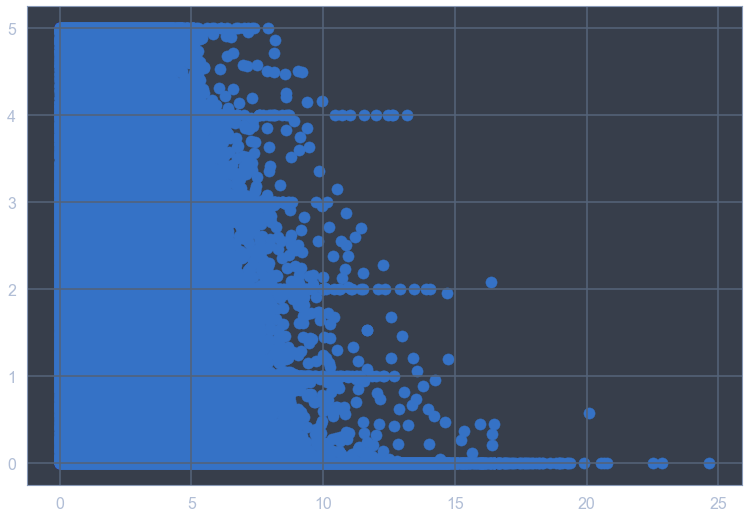

Scatterplot of Unscaled Feature 2 : 


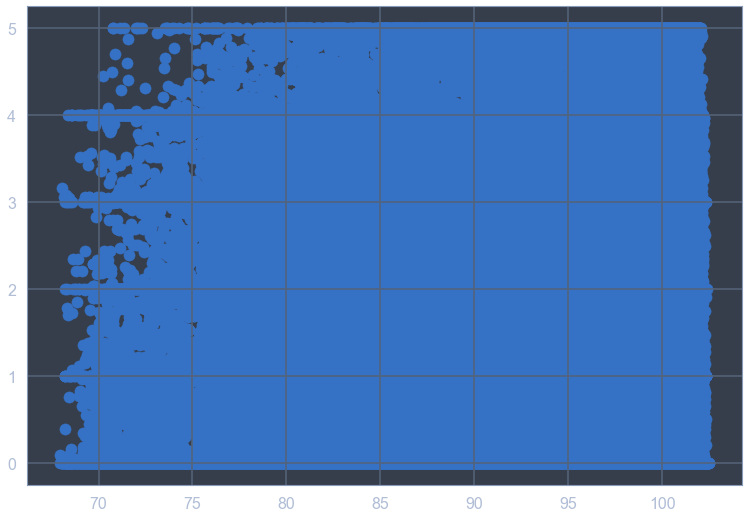

Scatterplot of Unscaled Feature 3 : 


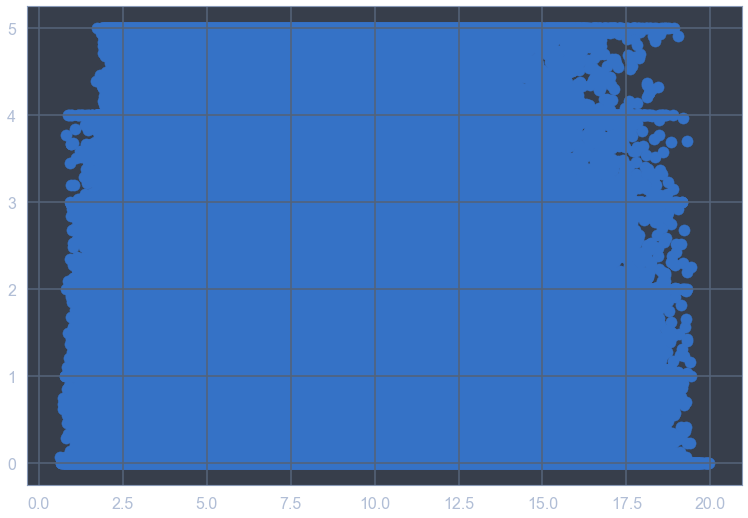

Scatterplot of Unscaled Feature 4 : 


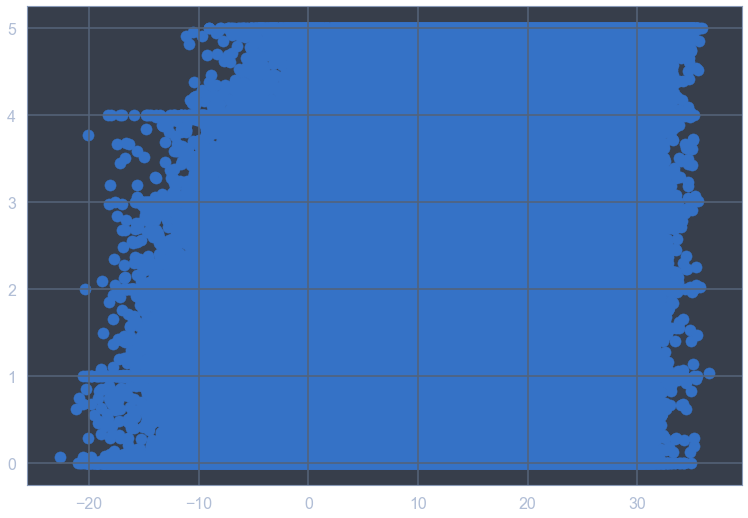

Scatterplot of Unscaled Feature 5 : 


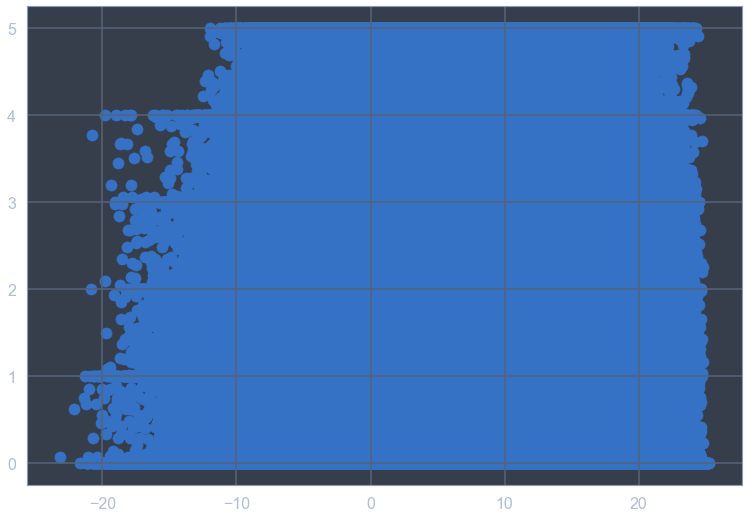

Scatterplot of Unscaled Feature 6 : 


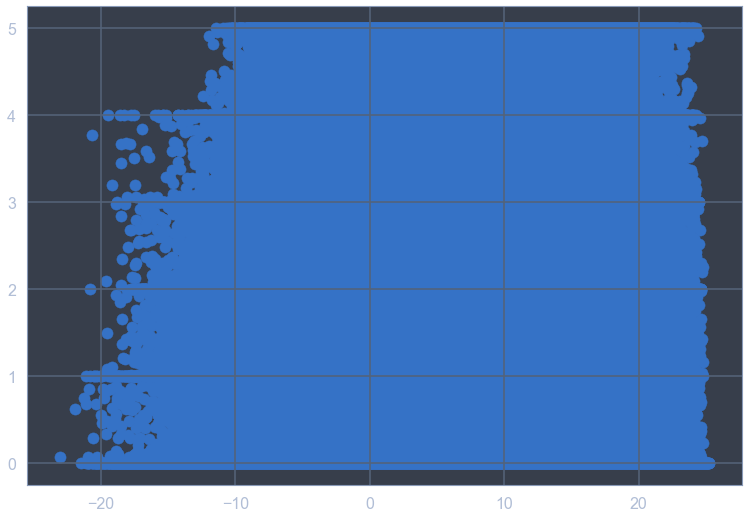

Scatterplot of Unscaled Feature 7 : 


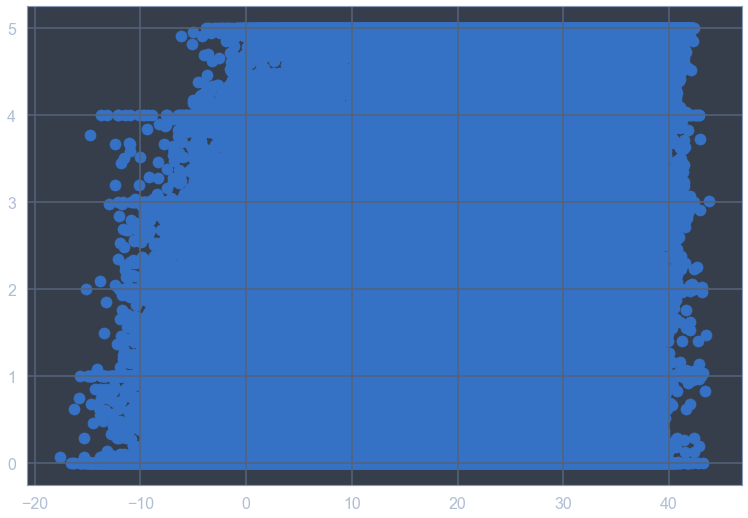

Scatterplot of Unscaled Feature 8 : 


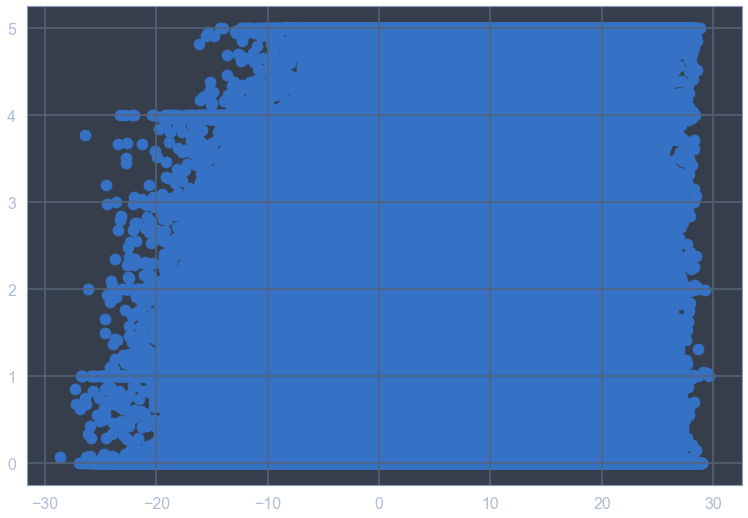

Scatterplot of Unscaled Feature 9 : 


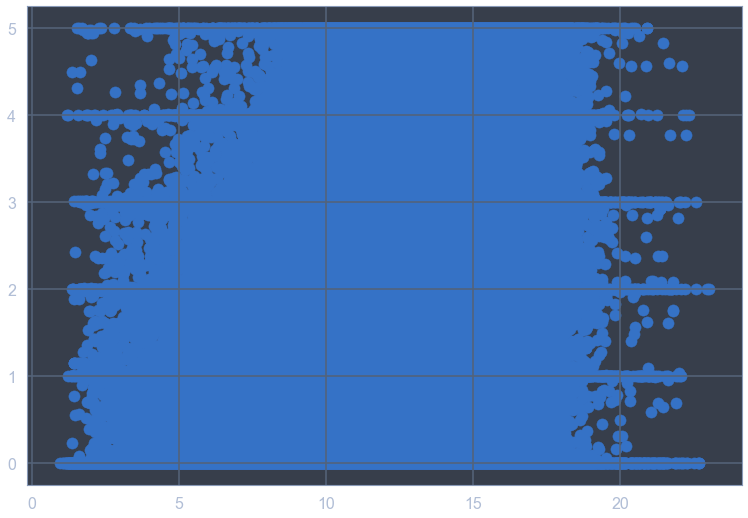

Scatterplot of Unscaled Feature 10 : 


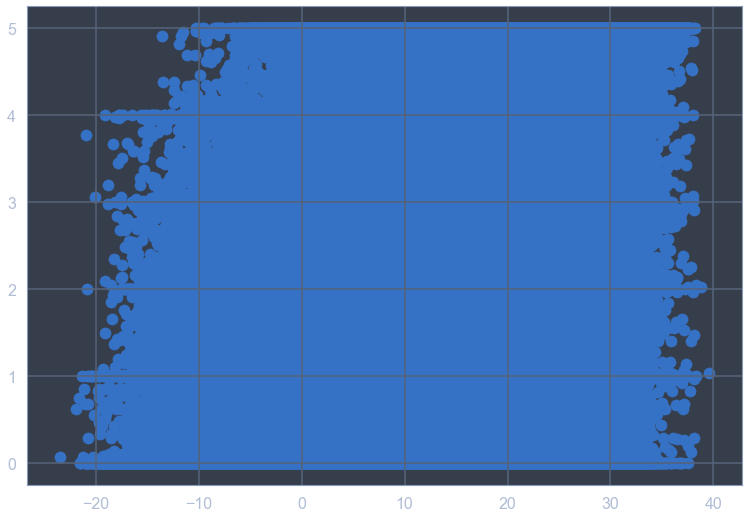

Scatterplot of Unscaled Feature 11 : 


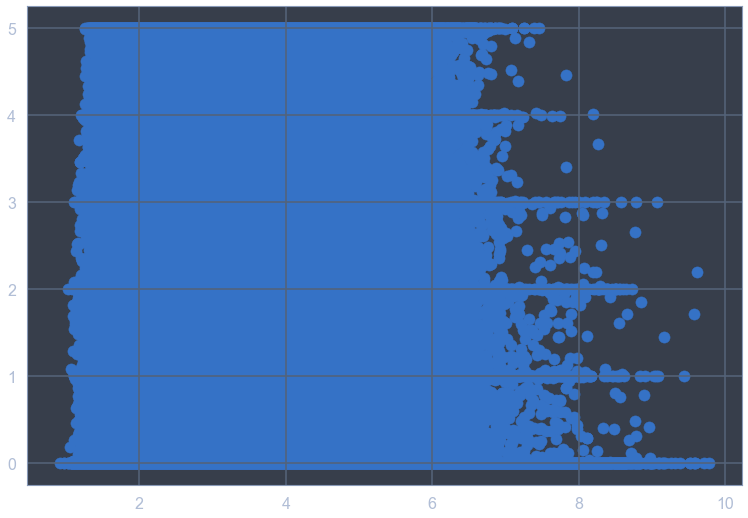

Scatterplot of Unscaled Feature 12 : 


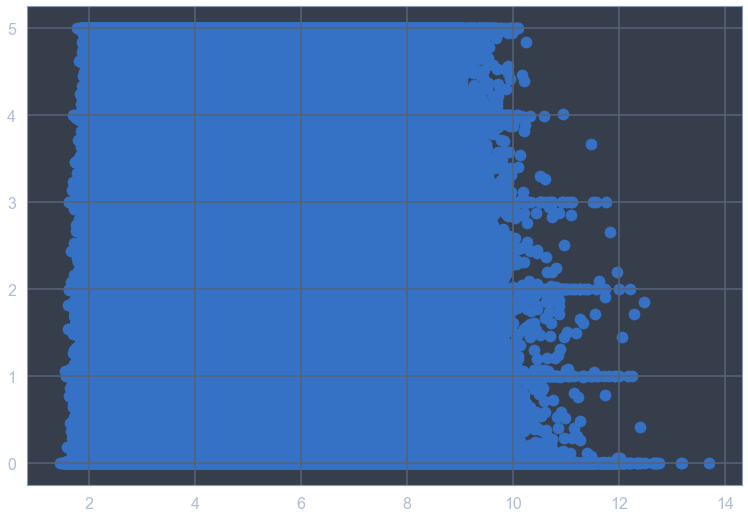

Scatterplot of Unscaled Feature 13 : 


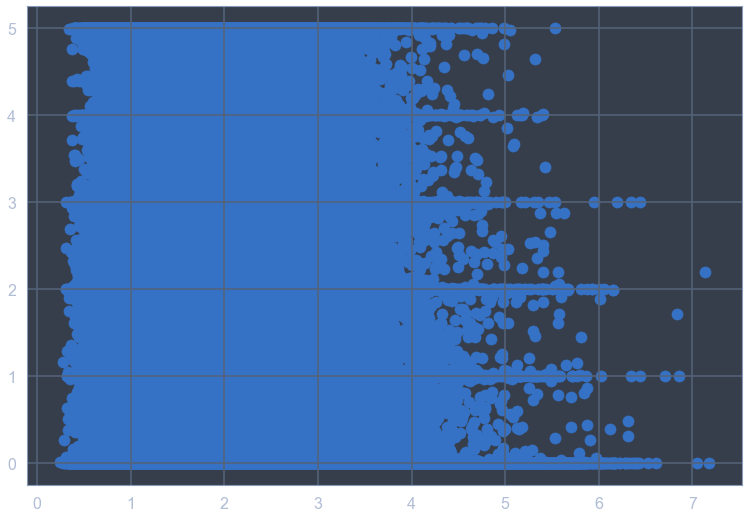

Scatterplot of Unscaled Feature 14 : 


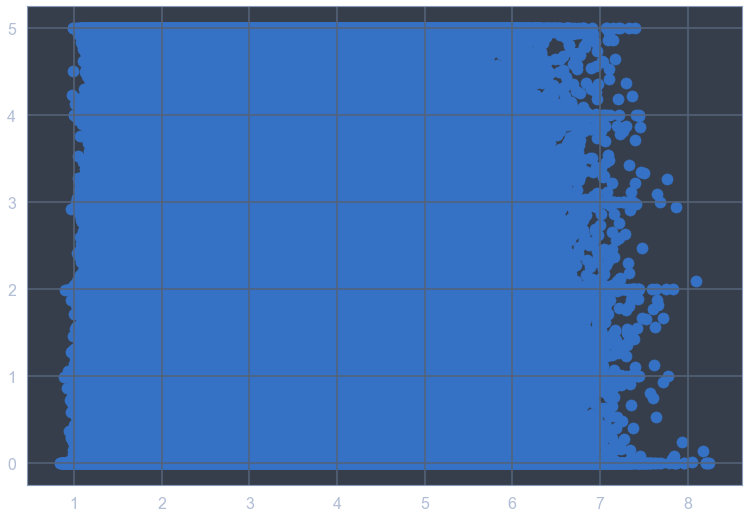

Scatterplot of Unscaled Feature 15 : 


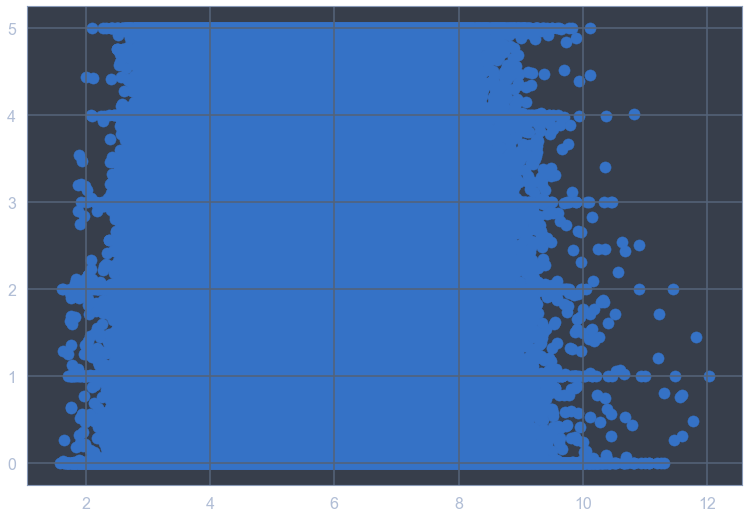

Scatterplot of Unscaled Feature 16 : 


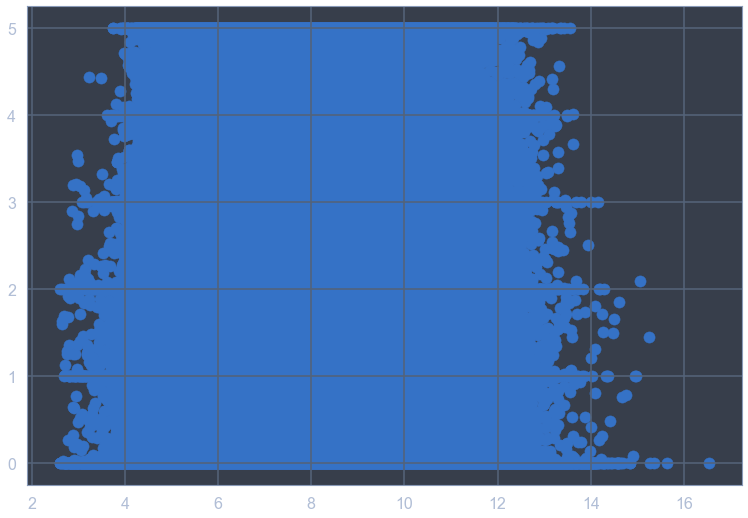

Scatterplot of Unscaled Feature 17 : 


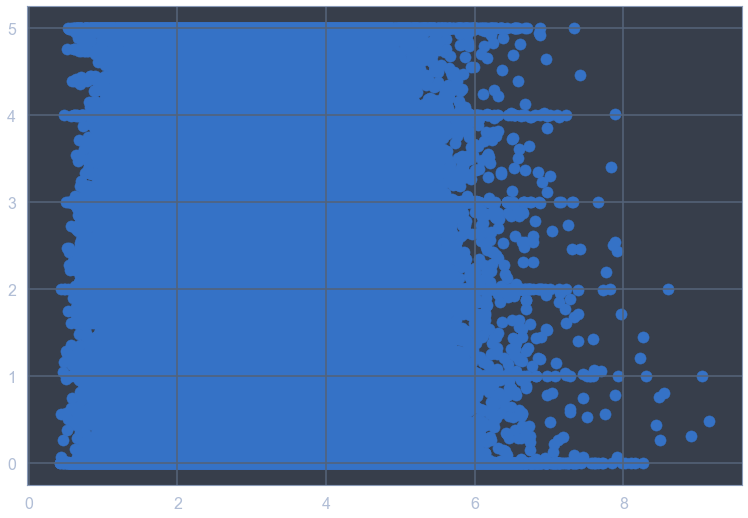

Scatterplot of Unscaled Feature 18 : 


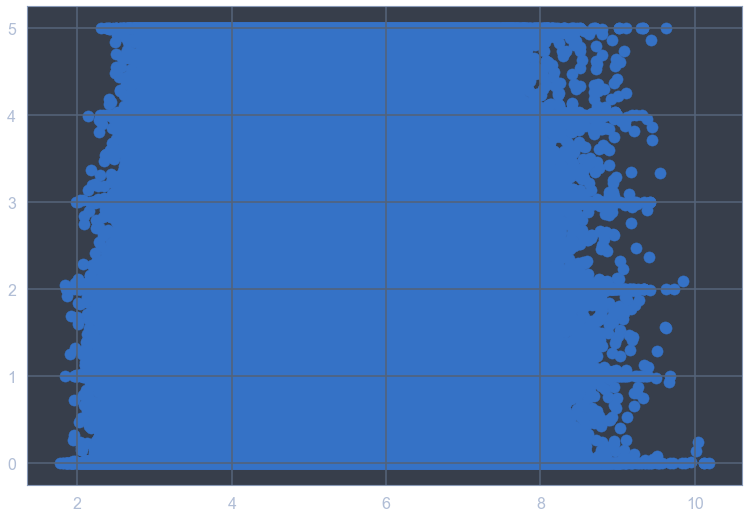

In [19]:
for i in np.arange(X_train.shape[1]):
    print('Scatterplot of Unscaled Feature', i+1, ': ')
    plt.scatter(X_train[:, i].reshape(-1, 1), y_target_train.reshape(-1, 1))
    plt.show()

# Plotting Correlation Heatmap of Unscaled Features

In [21]:
concatenatedXY = np.concatenate((X_train, y_target_train), axis=1)

In [24]:
concatenatedXY.shape

(639476, 19)

In [28]:
count = 0
for i in concatenatedXY:
    print(i, '\n')
    count += 1
    if count == 3:
        break

[3.21366667e+00 1.00772333e+02 4.85866667e+00 5.75400000e+00
 1.69800000e+00 1.75466667e+00 1.20340000e+01 9.90000000e-02
 1.19353333e+01 5.58833333e+00 2.49466667e+00 3.55000000e+00
 1.50633333e+00 2.04366667e+00 4.74800000e+00 6.63266667e+00
 2.85833333e+00 3.77366667e+00 1.00000000e+00] 

[  1.826      100.62533333   7.279       13.09966667   8.487
   8.495       20.51566667   6.121       14.39433333  12.72866667
   2.36033333   3.32333333   1.455        1.86933333   4.63866667
   6.544        2.73         3.81433333   1.4905    ] 

[  6.452      100.20766667   8.647       14.897       10.92166667
  10.928       21.71366667   8.31666667  13.39566667  14.848
   2.47566667   3.50233333   1.426        2.076        4.86033333
   6.804        2.83966667   3.96533333   0.929     ] 



In [29]:
dfForCorrelationHeatmap = pd.DataFrame(concatenatedXY, columns=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'Drought Scores'])

In [30]:
dfForCorrelationHeatmap

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,Drought Scores
0,3.213667,100.772333,4.858667,5.754000,1.698000,1.754667,12.034000,0.099000,11.935333,5.588333,2.494667,3.550000,1.506333,2.043667,4.748000,6.632667,2.858333,3.773667,1.0000
1,1.826000,100.625333,7.279000,13.099667,8.487000,8.495000,20.515667,6.121000,14.394333,12.728667,2.360333,3.323333,1.455000,1.869333,4.638667,6.544000,2.730000,3.814333,1.4905
2,6.452000,100.207667,8.647000,14.897000,10.921667,10.928000,21.713667,8.316667,13.395667,14.848000,2.475667,3.502333,1.426000,2.076000,4.860333,6.804000,2.839667,3.965333,0.9290
3,0.947333,100.222000,8.874000,17.188667,11.709333,11.713000,23.853333,10.448667,13.405000,17.034000,2.279333,3.345667,1.141000,2.202333,4.375000,6.245333,2.163667,4.082667,1.9995
4,1.835000,100.066000,11.772000,24.814333,16.069667,16.072333,32.288000,17.702000,14.586000,24.947000,2.142333,3.061667,1.229667,1.830000,4.197667,5.908667,2.378333,3.531000,2.0391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639471,0.297000,83.254333,6.630667,23.721667,4.772667,4.792333,31.946333,15.206000,16.740333,25.512000,3.254333,5.763667,1.289333,4.476000,4.723667,8.266333,1.960333,6.306000,1.5373
639472,1.085667,83.268000,5.797000,18.045333,2.715333,2.754000,25.687000,10.710333,14.976333,19.218667,3.063333,5.071333,1.265333,3.804333,4.465333,7.167000,1.822333,5.344667,1.4750
639473,2.926333,83.234667,5.638667,11.785667,2.385000,2.410000,18.947333,5.357667,13.590667,11.991333,3.180000,5.330000,1.021333,4.309333,4.617667,7.367667,1.586000,5.781667,0.0056
639474,0.476667,83.282667,4.412000,8.629000,-1.002667,-0.950667,16.304333,2.722000,13.582000,7.558667,3.388000,5.615667,1.488333,4.127000,5.132000,8.147667,2.274667,5.874333,0.0000


In [31]:
dfForCorrelationHeatmap.corr()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,Drought Scores
PRECTOT,1.000000,0.319454,0.409314,0.241257,0.427730,0.426975,0.181393,0.286897,-0.340497,0.230530,-0.262434,-0.293177,-0.175729,-0.330438,-0.225879,-0.257856,-0.115875,-0.320210,-0.330197
PS,0.319454,1.000000,0.332598,0.190109,0.401355,0.400997,0.133812,0.239926,-0.358301,0.187814,-0.075760,-0.146420,0.082094,-0.259031,-0.019472,-0.086647,0.130466,-0.242628,-0.188595
QV2M,0.409314,0.332598,1.000000,0.905308,0.971573,0.972078,0.861295,0.933245,0.007982,0.896811,-0.389802,-0.420221,-0.299574,-0.447233,-0.438148,-0.454962,-0.327385,-0.466987,-0.047051
T2M,0.241257,0.190109,0.905308,1.000000,0.932501,0.932981,0.992038,0.992637,0.320781,0.998617,-0.330067,-0.335416,-0.296631,-0.325146,-0.386481,-0.374077,-0.340703,-0.326955,0.113570
T2MDEW,0.427730,0.401355,0.971573,0.932501,1.000000,0.999990,0.893069,0.955290,0.055173,0.924119,-0.398880,-0.430637,-0.302653,-0.460723,-0.429662,-0.448828,-0.315495,-0.466650,-0.054866
T2MWET,0.426975,0.400997,0.972078,0.932981,0.999990,1.000000,0.893632,0.955729,0.055831,0.924611,-0.398425,-0.430047,-0.302532,-0.459929,-0.429409,-0.448429,-0.315604,-0.465926,-0.053951
T2M_MAX,0.181393,0.133812,0.861295,0.992038,0.893069,0.893632,1.000000,0.971304,0.434319,0.991036,-0.325326,-0.321271,-0.312233,-0.295876,-0.376165,-0.355213,-0.352704,-0.287207,0.157958
T2M_MIN,0.286897,0.239926,0.933245,0.992637,0.955290,0.955729,0.971304,1.000000,0.207618,0.990232,-0.338216,-0.351784,-0.284877,-0.355529,-0.398855,-0.394951,-0.332276,-0.367072,0.079034
T2M_RANGE,-0.340497,-0.358301,0.007982,0.320781,0.055173,0.055831,0.434319,0.207618,1.000000,0.325770,-0.057126,0.010940,-0.205280,0.129566,-0.036564,0.034826,-0.192219,0.208936,0.350342
TS,0.230530,0.187814,0.896811,0.998617,0.924119,0.924611,0.991036,0.990232,0.325770,1.000000,-0.303970,-0.309516,-0.272387,-0.300780,-0.364220,-0.350727,-0.321531,-0.304877,0.120789


<AxesSubplot:>

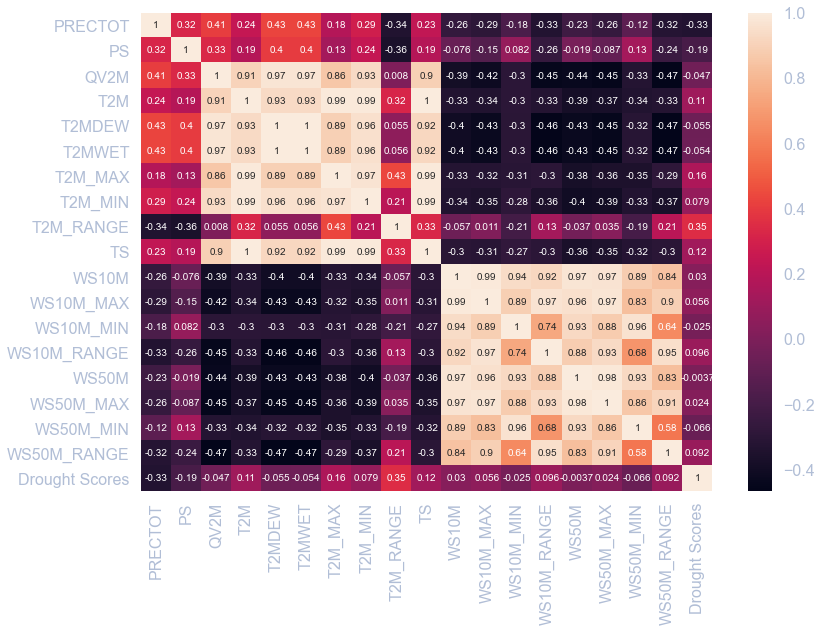

In [34]:
sns.heatmap(dfForCorrelationHeatmap.corr(), annot=True)

# Scaling Feature values:

In [35]:
X_train = scaleFeatures(X_train, fit=True)
X_valid = scaleFeatures(X_valid)
X_test = scaleFeatures(X_test)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [38]:
count = 0
for k in X_train:
    print(k)
    #for j in k:
    #    print(j)
    count += 1
    print('\n\n\n')
    if count == 3:
        break

[ 0.36213992  0.61076949 -0.31893346 -0.48554819 -0.37613629 -0.37463964
 -0.48326913 -0.49323174  0.17643929 -0.4885882  -0.42550656 -0.46084672
 -0.3171454  -0.49736327 -0.27566353 -0.30488056 -0.15164586 -0.37704036]




[-0.22860792  0.57412332  0.03630137 -0.03762348  0.08100465  0.08078829
  0.0299522  -0.10871786  0.96147707 -0.06234206 -0.48554827 -0.52955441
 -0.362748   -0.57616393 -0.32172448 -0.33226936 -0.23904654 -0.35515695]




[ 1.74074074  0.47000166  0.23708415  0.07197447  0.24494422  0.24518018
  0.10244257  0.0314788   0.64265191  0.06417272 -0.43399881 -0.47529554
 -0.38851051 -0.48274823 -0.22833872 -0.25195634 -0.16435868 -0.27390135]






In [40]:
count = 0
for k in y_target_train:
    print(k, '\n\n')
    count += 1
    if count == 3:
        break

[1.] 


[1.4905] 


[0.929] 




Scatterplot of Scaled Feature 1 : 


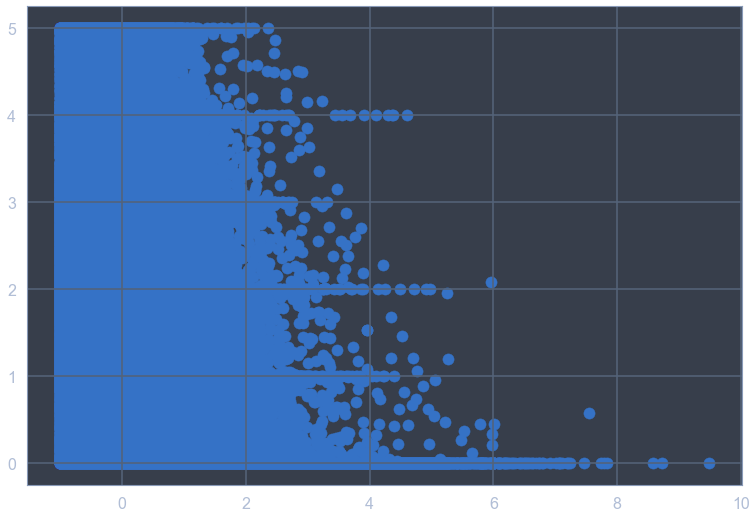

Scatterplot of Scaled Feature 2 : 


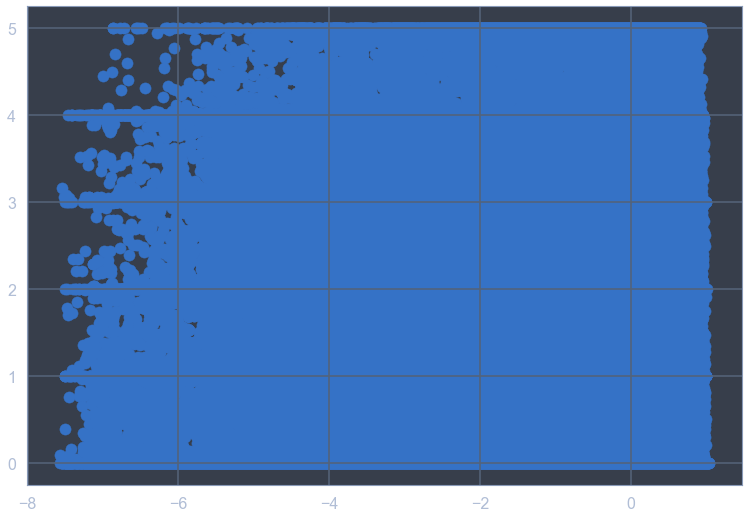

Scatterplot of Scaled Feature 3 : 


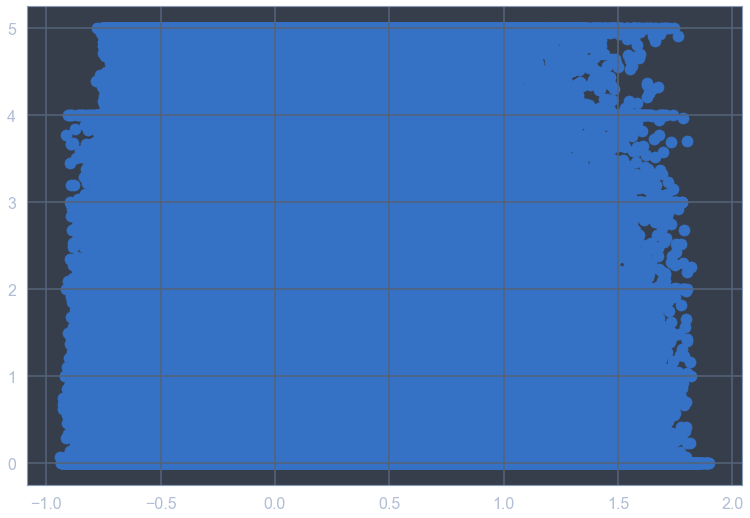

Scatterplot of Scaled Feature 4 : 


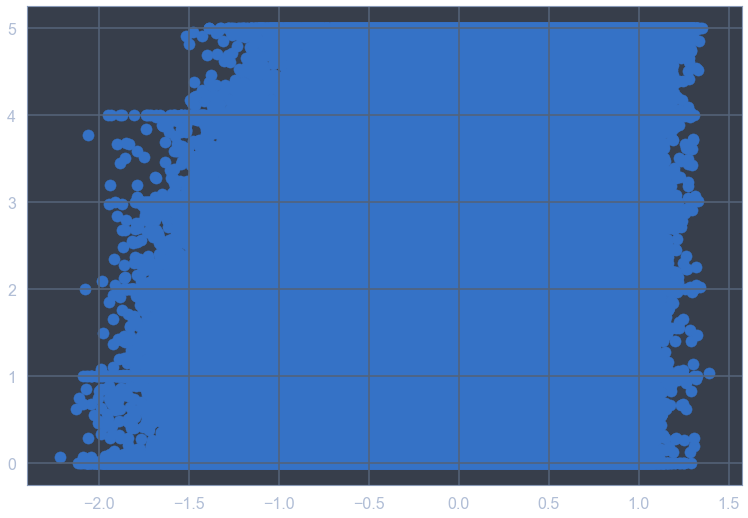

Scatterplot of Scaled Feature 5 : 


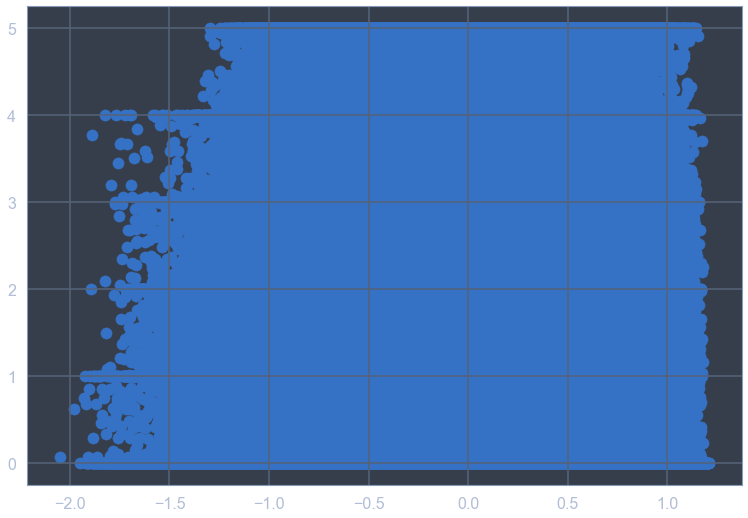

Scatterplot of Scaled Feature 6 : 


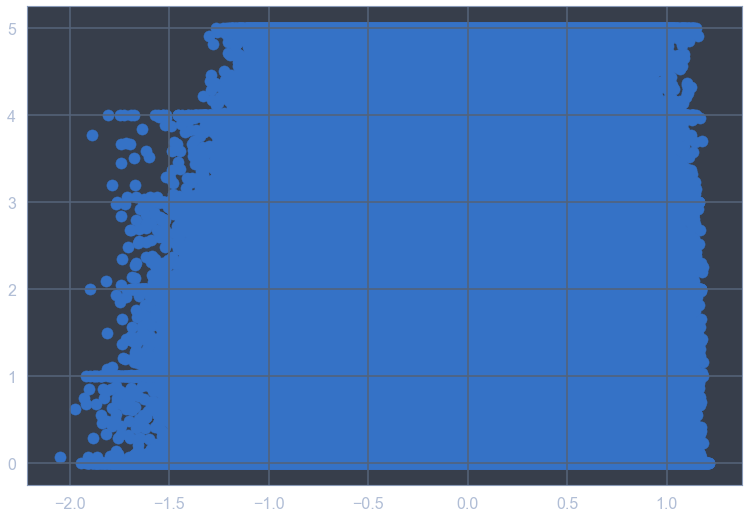

Scatterplot of Scaled Feature 7 : 


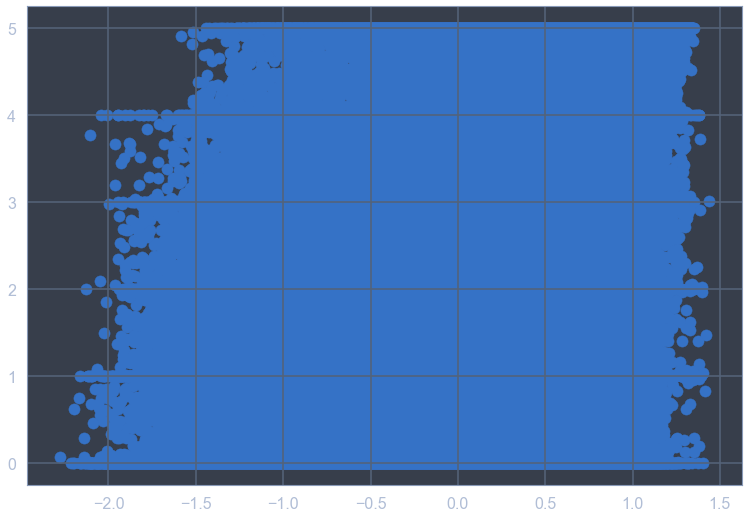

Scatterplot of Scaled Feature 8 : 


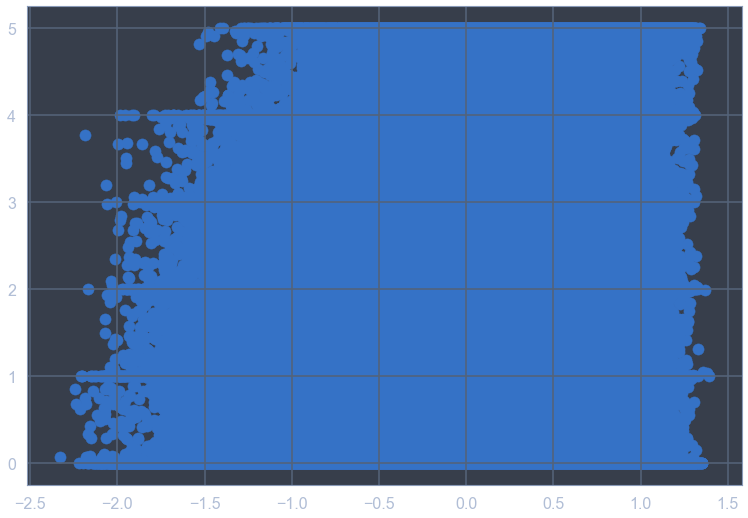

Scatterplot of Scaled Feature 9 : 


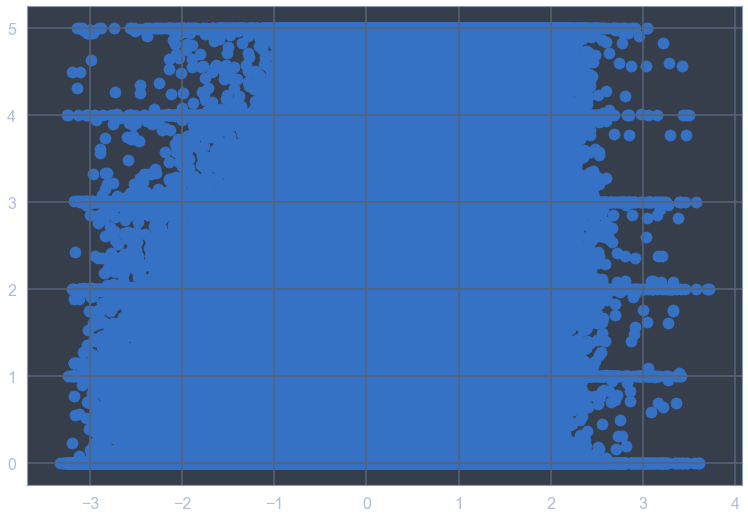

Scatterplot of Scaled Feature 10 : 


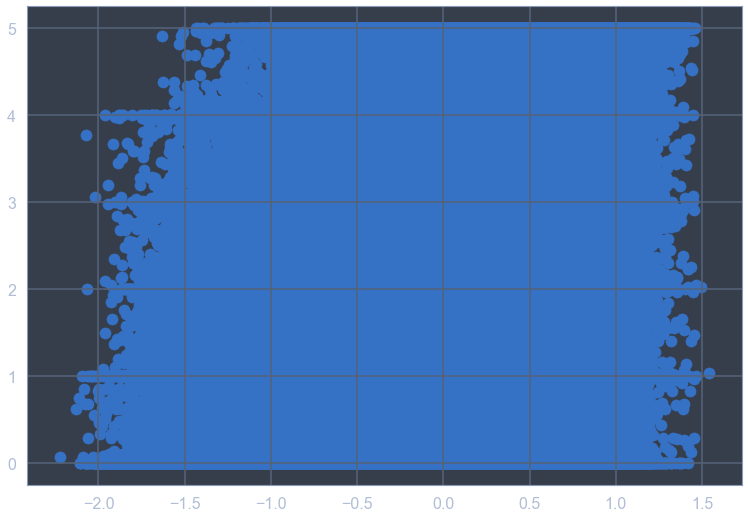

Scatterplot of Scaled Feature 11 : 


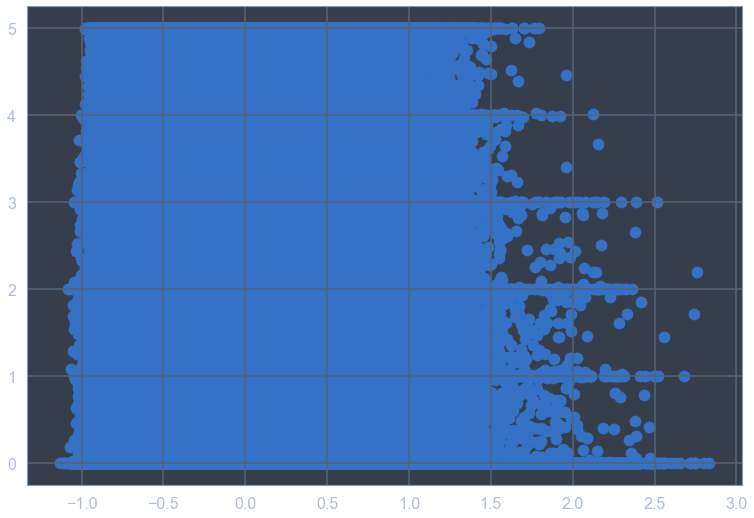

Scatterplot of Scaled Feature 12 : 


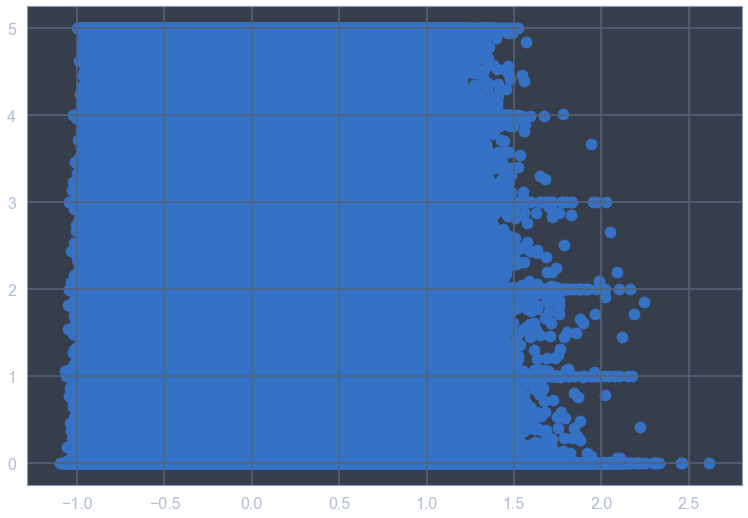

Scatterplot of Scaled Feature 13 : 


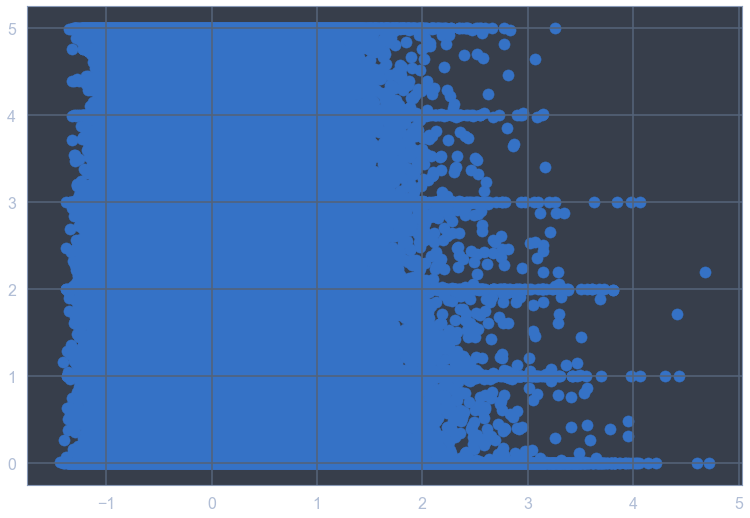

Scatterplot of Scaled Feature 14 : 


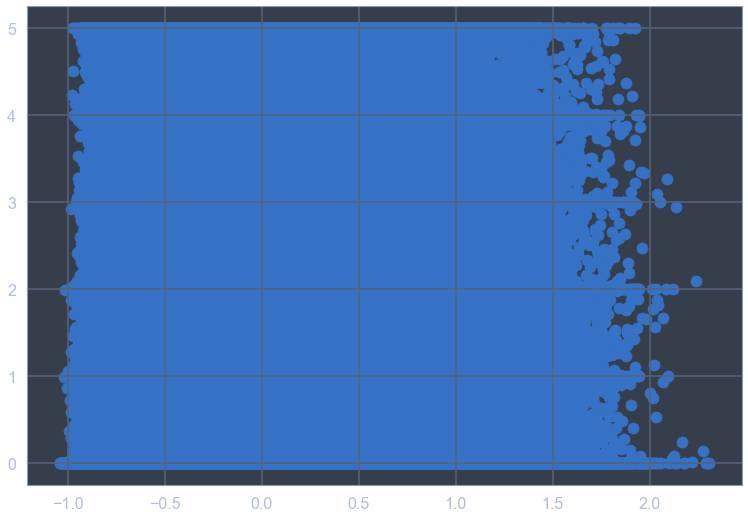

Scatterplot of Scaled Feature 15 : 


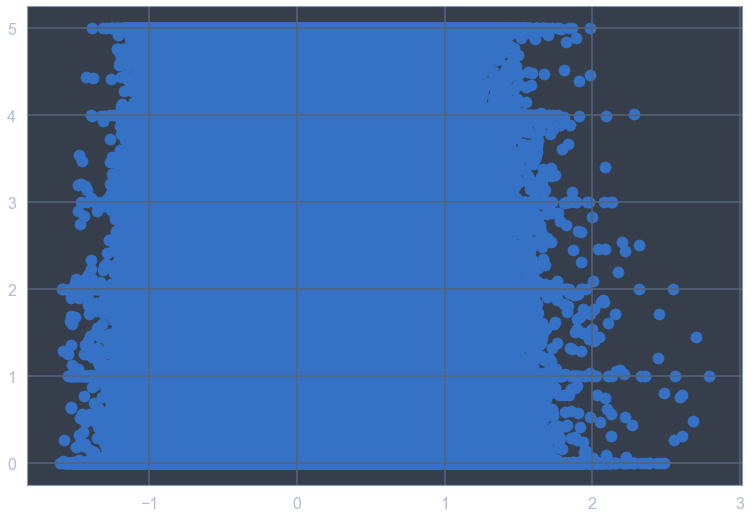

Scatterplot of Scaled Feature 16 : 


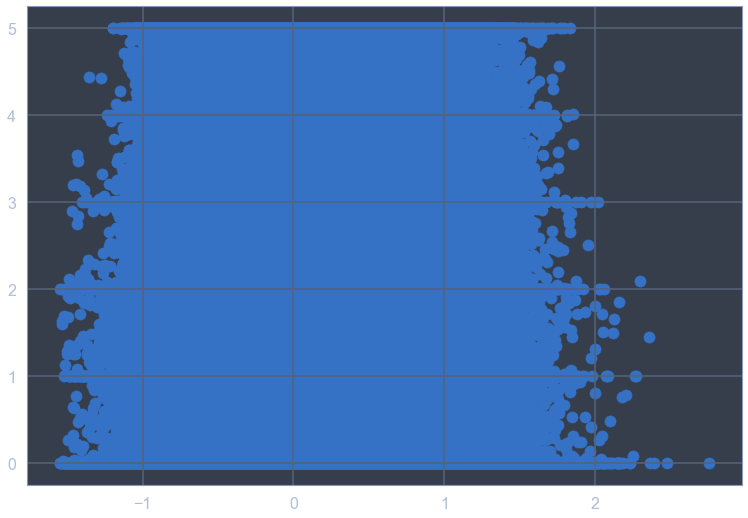

Scatterplot of Scaled Feature 17 : 


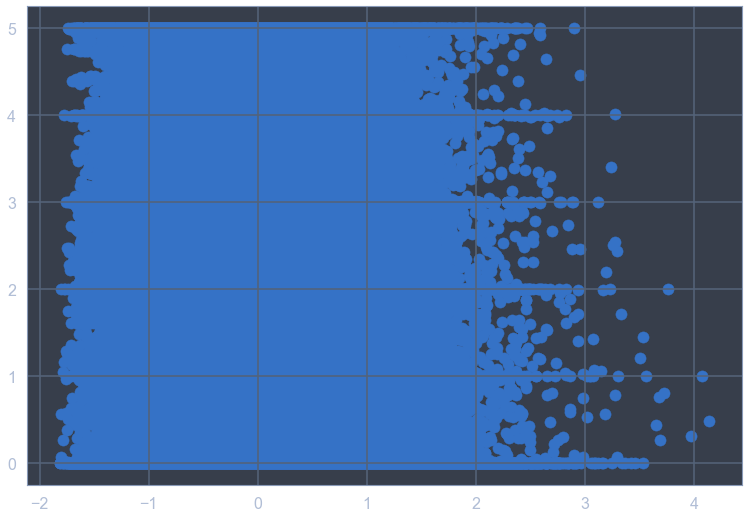

Scatterplot of Scaled Feature 18 : 


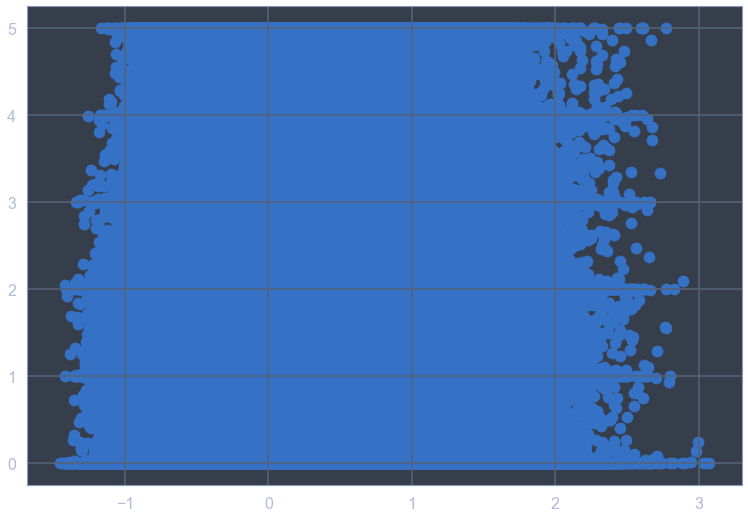

In [41]:
for i in np.arange(X_train.shape[1]):
    print('Scatterplot of Scaled Feature', i+1, ': ')
    plt.scatter(X_train[:, i], y_target_train)
    plt.show()

# Plotting Correlation Heatmap of Scaled Features

In [42]:
concatenatedXYScaled = np.concatenate((X_train, y_target_train), axis=1)

In [43]:
concatenatedXYScaled.shape

(639476, 19)

In [44]:
count = 0
for i in concatenatedXYScaled:
    print(i, '\n')
    count += 1
    if count == 3:
        break

[ 0.36213992  0.61076949 -0.31893346 -0.48554819 -0.37613629 -0.37463964
 -0.48326913 -0.49323174  0.17643929 -0.4885882  -0.42550656 -0.46084672
 -0.3171454  -0.49736327 -0.27566353 -0.30488056 -0.15164586 -0.37704036
  1.        ] 

[-0.22860792  0.57412332  0.03630137 -0.03762348  0.08100465  0.08078829
  0.0299522  -0.10871786  0.96147707 -0.06234206 -0.48554827 -0.52955441
 -0.362748   -0.57616393 -0.32172448 -0.33226936 -0.23904654 -0.35515695
  1.4905    ] 

[ 1.74074074  0.47000166  0.23708415  0.07197447  0.24494422  0.24518018
  0.10244257  0.0314788   0.64265191  0.06417272 -0.43399881 -0.47529554
 -0.38851051 -0.48274823 -0.22833872 -0.25195634 -0.16435868 -0.27390135
  0.929     ] 



In [45]:
dfForCorrelationHeatmapScaled = pd.DataFrame(concatenatedXYScaled, columns=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'Drought Scores'])

In [46]:
dfForCorrelationHeatmapScaled

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,Drought Scores
0,0.362140,0.610769,-0.318933,-0.485548,-0.376136,-0.374640,-0.483269,-0.493232,0.176439,-0.488588,-0.425507,-0.460847,-0.317145,-0.497363,-0.275664,-0.304881,-0.151646,-0.377040,1.0000
1,-0.228608,0.574123,0.036301,-0.037623,0.081005,0.080788,0.029952,-0.108718,0.961477,-0.062342,-0.485548,-0.529554,-0.362748,-0.576164,-0.321724,-0.332269,-0.239047,-0.355157,1.4905
2,1.740741,0.470002,0.237084,0.071974,0.244944,0.245180,0.102443,0.031479,0.642652,0.064173,-0.433999,-0.475296,-0.388511,-0.482748,-0.228339,-0.251956,-0.164359,-0.273901,0.9290
3,-0.602668,0.473575,0.270401,0.211716,0.297982,0.298221,0.231913,0.167610,0.645632,0.194667,-0.521752,-0.522785,-0.641694,-0.425644,-0.432804,-0.424526,-0.624745,-0.210762,1.9995
4,-0.224777,0.434685,0.695744,0.676715,0.591588,0.592770,0.742290,0.630747,1.022667,0.667038,-0.582986,-0.608871,-0.562926,-0.593943,-0.507513,-0.528521,-0.478547,-0.507623,2.0391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639471,-0.879523,-3.756357,-0.058855,0.610086,-0.169102,-0.169392,0.721616,0.471373,1.710440,0.700766,-0.085965,0.210165,-0.509920,0.602079,-0.285915,0.199753,-0.763224,0.985650,1.5373
639472,-0.543777,-3.752950,-0.181213,0.263954,-0.307634,-0.307117,0.342867,0.184318,1.147281,0.325082,-0.171335,0.000303,-0.531241,0.298478,-0.394748,-0.139827,-0.857208,0.468341,1.4750
639473,0.239818,-3.761260,-0.204452,-0.117749,-0.329877,-0.330360,-0.064947,-0.157458,0.704906,-0.106358,-0.119190,0.078711,-0.748001,0.526744,-0.330572,-0.077842,-1.018161,0.703498,0.0056
639474,-0.803037,-3.749294,-0.384491,-0.310236,-0.557987,-0.557432,-0.224873,-0.325749,0.702139,-0.370968,-0.026222,0.165303,-0.333136,0.444327,-0.113888,0.163097,-0.549149,0.753363,0.0000


In [47]:
dfForCorrelationHeatmapScaled.corr()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,Drought Scores
PRECTOT,1.000000,0.319454,0.409314,0.241257,0.427730,0.426975,0.181393,0.286897,-0.340497,0.230530,-0.262434,-0.293177,-0.175729,-0.330438,-0.225879,-0.257856,-0.115875,-0.320210,-0.330197
PS,0.319454,1.000000,0.332598,0.190109,0.401355,0.400997,0.133812,0.239926,-0.358301,0.187814,-0.075760,-0.146420,0.082094,-0.259031,-0.019472,-0.086647,0.130466,-0.242628,-0.188595
QV2M,0.409314,0.332598,1.000000,0.905308,0.971573,0.972078,0.861295,0.933245,0.007982,0.896811,-0.389802,-0.420221,-0.299574,-0.447233,-0.438148,-0.454962,-0.327385,-0.466987,-0.047051
T2M,0.241257,0.190109,0.905308,1.000000,0.932501,0.932981,0.992038,0.992637,0.320781,0.998617,-0.330067,-0.335416,-0.296631,-0.325146,-0.386481,-0.374077,-0.340703,-0.326955,0.113570
T2MDEW,0.427730,0.401355,0.971573,0.932501,1.000000,0.999990,0.893069,0.955290,0.055173,0.924119,-0.398880,-0.430637,-0.302653,-0.460723,-0.429662,-0.448828,-0.315495,-0.466650,-0.054866
T2MWET,0.426975,0.400997,0.972078,0.932981,0.999990,1.000000,0.893632,0.955729,0.055831,0.924611,-0.398425,-0.430047,-0.302532,-0.459929,-0.429409,-0.448429,-0.315604,-0.465926,-0.053951
T2M_MAX,0.181393,0.133812,0.861295,0.992038,0.893069,0.893632,1.000000,0.971304,0.434319,0.991036,-0.325326,-0.321271,-0.312233,-0.295876,-0.376165,-0.355213,-0.352704,-0.287207,0.157958
T2M_MIN,0.286897,0.239926,0.933245,0.992637,0.955290,0.955729,0.971304,1.000000,0.207618,0.990232,-0.338216,-0.351784,-0.284877,-0.355529,-0.398855,-0.394951,-0.332276,-0.367072,0.079034
T2M_RANGE,-0.340497,-0.358301,0.007982,0.320781,0.055173,0.055831,0.434319,0.207618,1.000000,0.325770,-0.057126,0.010940,-0.205280,0.129566,-0.036564,0.034826,-0.192219,0.208936,0.350342
TS,0.230530,0.187814,0.896811,0.998617,0.924119,0.924611,0.991036,0.990232,0.325770,1.000000,-0.303970,-0.309516,-0.272387,-0.300780,-0.364220,-0.350727,-0.321531,-0.304877,0.120789


<AxesSubplot:>

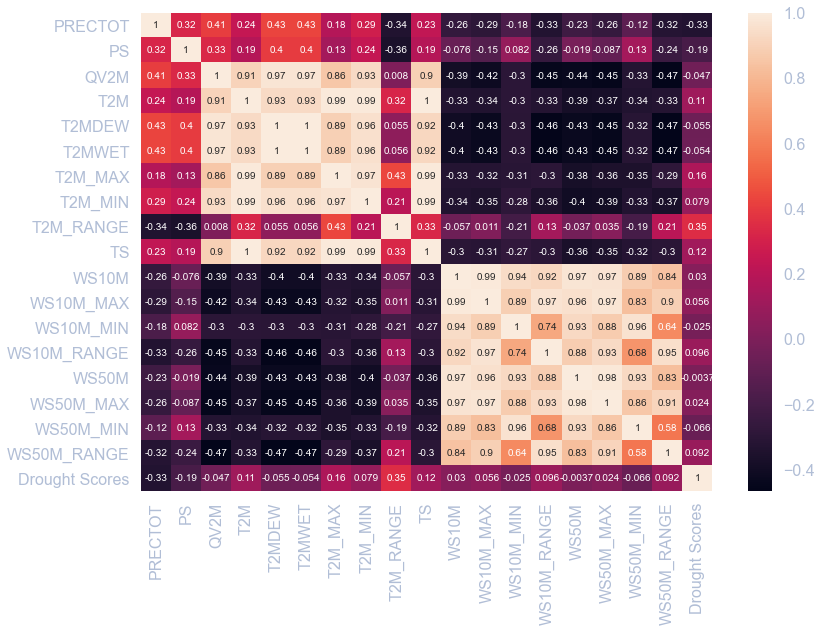

In [48]:
sns.heatmap(dfForCorrelationHeatmapScaled.corr(), annot=True)